# 0. Imports

Import τα απατούμενα packages της Python

In [141]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
import torch
from torch import nn
# from torchmetrics.classification import BinaryAccuracy
from tqdm.notebook import tqdm

# 1. Προετοιμασία δεδομένων

## 1.1 Φόρτωση των δεδομένων

In [142]:
df = pd.read_excel('movies.xlsx')
pd.set_option('display.max_columns', None)

# Truncate
pd.set_option('display.max_rows', False) # Change False to None to not truncate

## 1.2 Γενική εικόνα των δεδομένων

In [143]:
df.head()

,Film,Year,Script Type,Rotten Tomatoes critics,Metacritic critics,Average critics,Rotten Tomatoes Audience,Metacritic Audience,Rotten Tomatoes vs Metacritic deviance,Average audience,Audience vs Critics deviance,Primary Genre,Genre,Opening Weekend,Opening weekend ($million),Domestic Gross,Domestic gross ($million),Foreign Gross ($million),Foreign Gross,Worldwide Gross,Worldwide Gross ($million),of Gross earned abroad,Budget ($million),Budget recovered,Budget recovered opening weekend,Distributor,IMDb Rating,IMDB vs RT disparity,Release Date (US),Oscar Winners,Oscar Detail
0,300,2007,adaptation,60,51,56,89.0,71,18,80,-25,action,"period, action",70885301,70.89,210614939,210.61,245.45,245453242,456068181,456.0,53.82%,65,701.64%,109.05%,NaN,NaN,NaN,"Mar 9, 2007",NaN,NaN
1,3:10 to Yuma,2007,remake,88,76,82,86.0,73,13,80,3,western,western,14035033,14.04,53606916,53.61,16.17,16173815,69780731,70.0,23.18%,50,139.56%,28.07%,NaN,NaN,NaN,"Sep 7, 2007",NaN,NaN
2,30 Days of Night,2007,adaptation,50,53,52,56.0,65,-9,61,-9,horror,horror,15951902,15.95,39568996,39.57,35.53,35526091,75095087,75.0,47.31%,32,234.67%,49.85%,NaN,NaN,NaN,"Oct 19, 2007",NaN,NaN
3,Across the Universe,2007,original screenplay,54,56,55,82.0,73,9,78,-23,musical,musical,3824988,3.82,24343673,24.34,5.02,5023470,29367143,29.0,17.11%,45,65.26%,8.50%,NaN,NaN,NaN,"Oct 12, 2007",NaN,NaN
4,Alien vs. Predator - Requiem,2007,sequel,14,29,22,31.0,45,-14,38,-17,sci-fi,"sci-fi, horror",10059425,10.06,41797066,41.80,87.09,87086650,128883716,129.0,67.57%,40,322.21%,25.15%,NaN,NaN,NaN,"Dec 25, 2007",NaN,NaN


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402 entries, 0 to 1401
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Film                                     1402 non-null   object 
 1   Year                                     1402 non-null   int64  
 2   Script Type                              1402 non-null   object 
 3   Rotten Tomatoes  critics                 1401 non-null   object 
 4   Metacritic  critics                      1402 non-null   object 
 5   Average critics                          1402 non-null   object 
 6   Rotten Tomatoes Audience                 1401 non-null   float64
 7   Metacritic Audience                      1402 non-null   object 
 8   Rotten Tomatoes vs Metacritic  deviance  1402 non-null   object 
 9   Average audience                         1402 non-null   object 
 10  Audience vs Critics deviance             1402 no

In [145]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,1402.0,2012.140514,3.190291,2007.0,2009.0000,2012.000,2015.0000,2017.00
Rotten Tomatoes Audience,1401.0,62.122769,17.435737,17.0,49.0000,62.000,76.0000,98.00
Opening weekend ($million),1402.0,23.200357,28.547541,0.0,6.6025,14.200,28.5975,247.97
Domestic gross ($million),1402.0,74.058024,87.389737,0.0,21.0900,44.045,92.5900,936.66
Worldwide Gross ($million),1402.0,173.008302,233.859025,0.0,38.0000,88.690,208.7500,2781.50
Distributor,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMDb Rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMDB vs RT disparity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
df.describe(include='object').T

,count,unique,top,freq
Film,1402,1396,Big Miracle,2
Script Type,1402,17,original screenplay,546
Rotten Tomatoes critics,1401,102,93,29
Metacritic critics,1402,90,51,39
Average critics,1402,196,64,25
Metacritic Audience,1402,78,66,50
Rotten Tomatoes vs Metacritic deviance,1402,82,-1,58
Average audience,1402,116,58,45
Audience vs Critics deviance,1402,78,-5,54
...,...,...,...,...


# 2. Data cleanup

## 2.1 Έλεγχος για διπλότυπα

In [147]:
df[df.duplicated(subset=['Film'], keep=False)]

,Film,Year,Script Type,Rotten Tomatoes critics,Metacritic critics,Average critics,Rotten Tomatoes Audience,Metacritic Audience,Rotten Tomatoes vs Metacritic deviance,Average audience,Audience vs Critics deviance,Primary Genre,Genre,Opening Weekend,Opening weekend ($million),Domestic Gross,Domestic gross ($million),Foreign Gross ($million),Foreign Gross,Worldwide Gross,Worldwide Gross ($million),of Gross earned abroad,Budget ($million),Budget recovered,Budget recovered opening weekend,Distributor,IMDb Rating,IMDB vs RT disparity,Release Date (US),Oscar Winners,Oscar Detail
681,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.45,36931089,36.93,20.79,20788004,57719093,58.00,36.02%,70,82.46%,19.22%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
682,That's My Boy,2012,original screenplay,20,31,26,53.0,54,-1,54,-28,NaN,comedy,13453714,13.00,36931089,37.00,20.79,20788004,57719093,58.00,36.02%,70,82.46,18.57%,NaN,NaN,NaN,"Jun 15, 2012",NaN,NaN
703,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,7.76,20157300,20.16,4.56,4561915,24719215,25.00,18.45%,40,61.80%,19.40%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
704,Big Miracle,2012,adaptation,74,61,68,64.0,59,5,62,6,NaN,romance,7760205,8.00,20157300,20.00,4.56,4561915,24719215,25.00,18.45%,40,61.8,20.00%,NaN,NaN,NaN,"Feb 3, 2012",NaN,NaN
709,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.00,20275446,20.00,10.81,10808153,31083599,31.00,34.77%,35,88.81,17.14%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
710,Premium Rush,2012,original screenplay,76,66,71,60.0,68,-8,64,7,NaN,"action, crime, thriller",6030164,6.03,20275446,20.28,10.81,10808153,31083599,31.00,34.77%,35,88.81%,17.23%,NaN,NaN,NaN,"Aug 24, 2012",NaN,NaN
713,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,0.74,16377274,16.38,11.88,11880786,28258060,28.00,42.04%,32,88.31%,2.30%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
714,The Master,2012,original screenplay,85,86,86,59.0,69,-10,64,22,NaN,drama,736311,1.00,16377274,16.00,11.88,11880786,28258060,28.00,42.04%,32,88.31,3.13%,NaN,NaN,NaN,"Sep 21, 2012",NaN,NaN
1001,The Good Dinosaur,2015,original screenplay,77,66,72,66.0,70,-4,68,4,NaN,Adventure,39155217,39.00,123087120,123.09,209.12,209120551,332207671,332.21,62.95%,200,166%,19.58%,NaN,NaN,NaN,"Nov 25, 2015",NaN,NaN
1062,The Big Short,2015,adaptation,87,81,84,89.0,89,0,89,-5,NaN,drama,10531026,10.53,60900477,60.90,41.80,41800000,102700477,103.00,40.70%,28,366.79%,37.61%,NaN,NaN,NaN,"December 11, 2015",NaN,NaN


In [148]:
df = df.drop_duplicates(subset=['Film'])

## 2.2 Outlier detection TODO

In [149]:
# Critics scores must be between 0 and 100
print(df['Rotten Tomatoes Audience '].min(), df['Rotten Tomatoes Audience '].max())

# Budget columns must not be negative

17.0 98.0


## 2.3 Handle missing values

In [150]:
missing_data = df.isnull().sum()
print(missing_data)

Film                                          0
Year                                          0
Script Type                                   0
Rotten Tomatoes  critics                      1
Metacritic  critics                           0
Average critics                               0
Rotten Tomatoes Audience                      1
Metacritic Audience                           0
Rotten Tomatoes vs Metacritic  deviance       0
Average audience                              0
Audience vs Critics deviance                  0
Primary Genre                              1377
                                           ... 
Worldwide Gross                               0
Worldwide Gross ($million)                    0
 of Gross earned abroad                       0
Budget ($million)                             0
 Budget recovered                             0
 Budget recovered opening weekend             0
Distributor                                1396
IMDb Rating                             

In [151]:
# Print lines with missing values
df[df['Rotten Tomatoes  critics'].isnull() | df['Rotten Tomatoes Audience '].isnull() | df['Genre'].isnull() | df.isin(['-']).any(axis=1)]

,Film,Year,Script Type,Rotten Tomatoes critics,Metacritic critics,Average critics,Rotten Tomatoes Audience,Metacritic Audience,Rotten Tomatoes vs Metacritic deviance,Average audience,Audience vs Critics deviance,Primary Genre,Genre,Opening Weekend,Opening weekend ($million),Domestic Gross,Domestic gross ($million),Foreign Gross ($million),Foreign Gross,Worldwide Gross,Worldwide Gross ($million),of Gross earned abroad,Budget ($million),Budget recovered,Budget recovered opening weekend,Distributor,IMDb Rating,IMDB vs RT disparity,Release Date (US),Oscar Winners,Oscar Detail
504,Paranormal Activity 2,2010,sequel,NaN,53,53,NaN,58,-58,58,-5,NaN,horror,40670000,40.67,84750000,84.75,92.76,92760000,"177,510,000",177.51,52.26%,3,5917.00%,1355.67%,NaN,NaN,NaN,"Oct 22, 2010",NaN,NaN
930,Deliver Us From Evil,2014,adaptation,28,40,34,42.0,59,-17,51,-17,NaN,NaN,9740471,9.74,30477122,30.48,57.36,57360693,87937815,88.00,65.23%,30,293.13%,32.47%,NaN,NaN,NaN,"Jul 2, 2014",NaN,NaN
1268,Baahubali 2: The Conclusion,2017,sequel,100,-,-,87.0,85,2,86,-,NaN,"action, adventure",10430497,10.43,20186659,20.19,121.32,121319777,141506436,141.51,85.73%,39,362.84%,26.74%,NaN,NaN,NaN,"Apr 28, 2017",NaN,NaN
1272,Beatriz At Dinner,2017,original screenplay,75,68,72,56.0,52,4,54,18,NaN,comedy,141959,0.14,7115854,7.12,0.00,0,7115854,7.12,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1317,Let there be Light,2017,original screenplay,60,-,-,78.0,55,23,67,-,NaN,drama,1729535,1.73,7184198,7.18,0.00,0,7184198,7.18,0.00%,3,239.47%,57.65%,NaN,NaN,NaN,"Nov 10, 2017",NaN,NaN
1322,Lowriders,2017,original screenplay,55,57,56,63.0,-,-,-,-,NaN,drama,2403885,2.40,6179955,6.18,0.00,0,6179955,6.18,0.00%,1,686.66%,267.10%,NaN,NaN,NaN,"May 12, 2017",NaN,NaN
1325,Megan Leavey,2017,based on a true story,84,66,75,83.0,65,18,74,1,NaN,drama,3810867,3.81,13406883,13.41,0.00,0,13406883,13.41,0.00%,-,-,-,NaN,NaN,NaN,"Jun 9, 2017",NaN,NaN
1367,The Glass Castle,2017,"adaptation, based on a true story",49,56,53,74.0,63,11,69,-16,NaN,drama,4678548,4.68,17273059,17.27,4.50,4497986,21771045,21.77,20.66%,-,-,-,NaN,NaN,NaN,"Aug 11, 2017",NaN,NaN
1375,The Man Who Invented Christmas,2017,"adaptation, based on a true story",80,60,70,84.0,61,23,73,-3,NaN,drama,1353297,1.35,4664004,4.66,0.00,0,4664004,4.66,0.00%,-,-,-,NaN,NaN,NaN,"Nov 22, 2017",NaN,NaN
1388,Til Death Do Us Part,2017,original screenplay,-,-,-,64.0,-,-,-,-,NaN,thriller,1527289,1.53,3455267,3.46,0.00,0,3455267,3.46,0.00%,-,-,-,NaN,NaN,NaN,"Sep 29, 2017",NaN,NaN


In [152]:
# Drop lines that contain null or invalid values
df = df.dropna(subset=['Genre', 'Rotten Tomatoes  critics', 'Rotten Tomatoes Audience '])
df = df[~df.isin(['-']).any(axis=1)]

# 3. Prediction Model

## 3.1 Dataset preprocessing

### Convert `script type` and `genre` to 1 hot encoding

In [153]:
# Convert strings to lowercase
df['Script Type'] = df['Script Type'].str.lower()

# Extract all unique script type names
script_types = df['Script Type'].unique()

# Split strings and remove trailing spaces
types = []
for str in script_types:
    types.append(re.split(' / |, ',str))
script_types = [j.strip() for sub in types for j in sub]

#Convert to set to remove dublicates
script_types = set(script_types)

# Insert columns for each coresponding script type
for i, item in enumerate(script_types):
    df.insert(i+1, 'st_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df.index:
    for script in script_types:
        if script in df.at[i, 'Script Type']:
            df.at[i, 'st_'+script] = 1

# Drop script type and primary genre columns from dataframe
df = df.drop(['Script Type'], axis=1)

{'original screenplay', 'prequel', 'sequel', 'remake', 'documentary', 'adaptation', 'based on a true story', 'reboot'}


In [154]:
# Convert genres to lower to avoid possible dublication
df['Genre'] = df['Genre'].str.lower()
genres = df['Genre'].unique()

# Split strings and remove trailing spaces
unique_genres = []
for str in genres:
    unique_genres.append(re.split(', |. ',str))
genre_types = [j.strip() for sub in unique_genres for j in sub]

#Convert to set to remove dublicates
genre_types = set(genre_types)

# Remove invalid values
genre_types.remove('')
genre_types.remove('adventur')
genre_types.remove('biograph')
genre_types.remove('comed')
genre_types.remove('crim')
genre_types.remove('documentar')
genre_types.remove('dram')
genre_types.remove('famiily')
genre_types.remove('famil')
genre_types.remove('fantas')
genre_types.remove('horro')
genre_types.remove('musi')
genre_types.remove('music')
genre_types.remove('myster')
genre_types.remove('romanti')
genre_types.remove('sci-f')
genre_types.remove('sport')
genre_types.remove('thriler')
genre_types.remove('thrille')

# Insert columns for each coresponding script type
for i, item in enumerate(genre_types):
    df.insert(i+8, 'gen_'+item, 0)

# 1 hot encoding for corresponding script type
for i in df.index:
    for genre in genre_types:
        if genre in df.at[i, 'Genre']:
            df.at[i, 'gen_'+genre] = 1

# Drop original genre column
df = df.drop(['Genre'], axis=1)

In [155]:
# Drop unecessary primary genre
df = df.drop(['Primary Genre'], axis=1)

In [156]:
# Convert Oscar Winners to 1 hot encoding
df['Oscar Winners'] = df["Oscar Winners"].notnull().astype("int")

### Drop unecessary columns for model training

In [157]:
df = df.drop(['Distributor', 'IMDb Rating', 'IMDB vs RT disparity', 'Opening Weekend', 'Domestic Gross', 'Foreign Gross', 'Worldwide Gross', 'Film', 'Year', 'Release Date (US)', 'Oscar Detail', 'Rotten Tomatoes vs Metacritic  deviance', 'Audience vs Critics deviance ', 'Worldwide Gross ($million)', ' of Gross earned abroad', 'Average audience ', 'Average critics ', ' Budget recovered', ' Budget recovered opening weekend'], axis=1)

### Fix decimal points in strings for conversion to floating points numbers

In [161]:
df = df.replace(',','', regex=True)
# df = df.astype('float32')

### Dataset overview

In [162]:
df.head()

,st_original screenplay,st_prequel,st_sequel,st_remake,st_documentary,st_adaptation,st_based on a true story,gen_action,gen_mystery,gen_animation,gen_musical,gen_crime,gen_sports,gen_thriller,gen_period,gen_documentary,gen_comedy,gen_romance,gen_adventure,gen_western,gen_fantasy,gen_drama,gen_war,gen_family,gen_sci-fi,gen_biography,gen_history,gen_horror,st_reboot,Rotten Tomatoes critics,Metacritic critics,Rotten Tomatoes Audience,Metacritic Audience,Opening weekend ($million),Domestic gross ($million),Foreign Gross ($million),Budget ($million),Oscar Winners
0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,51,89.0,71,70.89,210.61,245.45,65,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,88,76,86.0,73,14.04,53.61,16.17,50,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,50,53,56.0,65,15.95,39.57,35.53,32,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,56,82.0,73,3.82,24.34,5.02,45,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,14,29,31.0,45,10.06,41.80,87.09,40,0


## 3.2 Dataset feature exploration

### Build corelation map

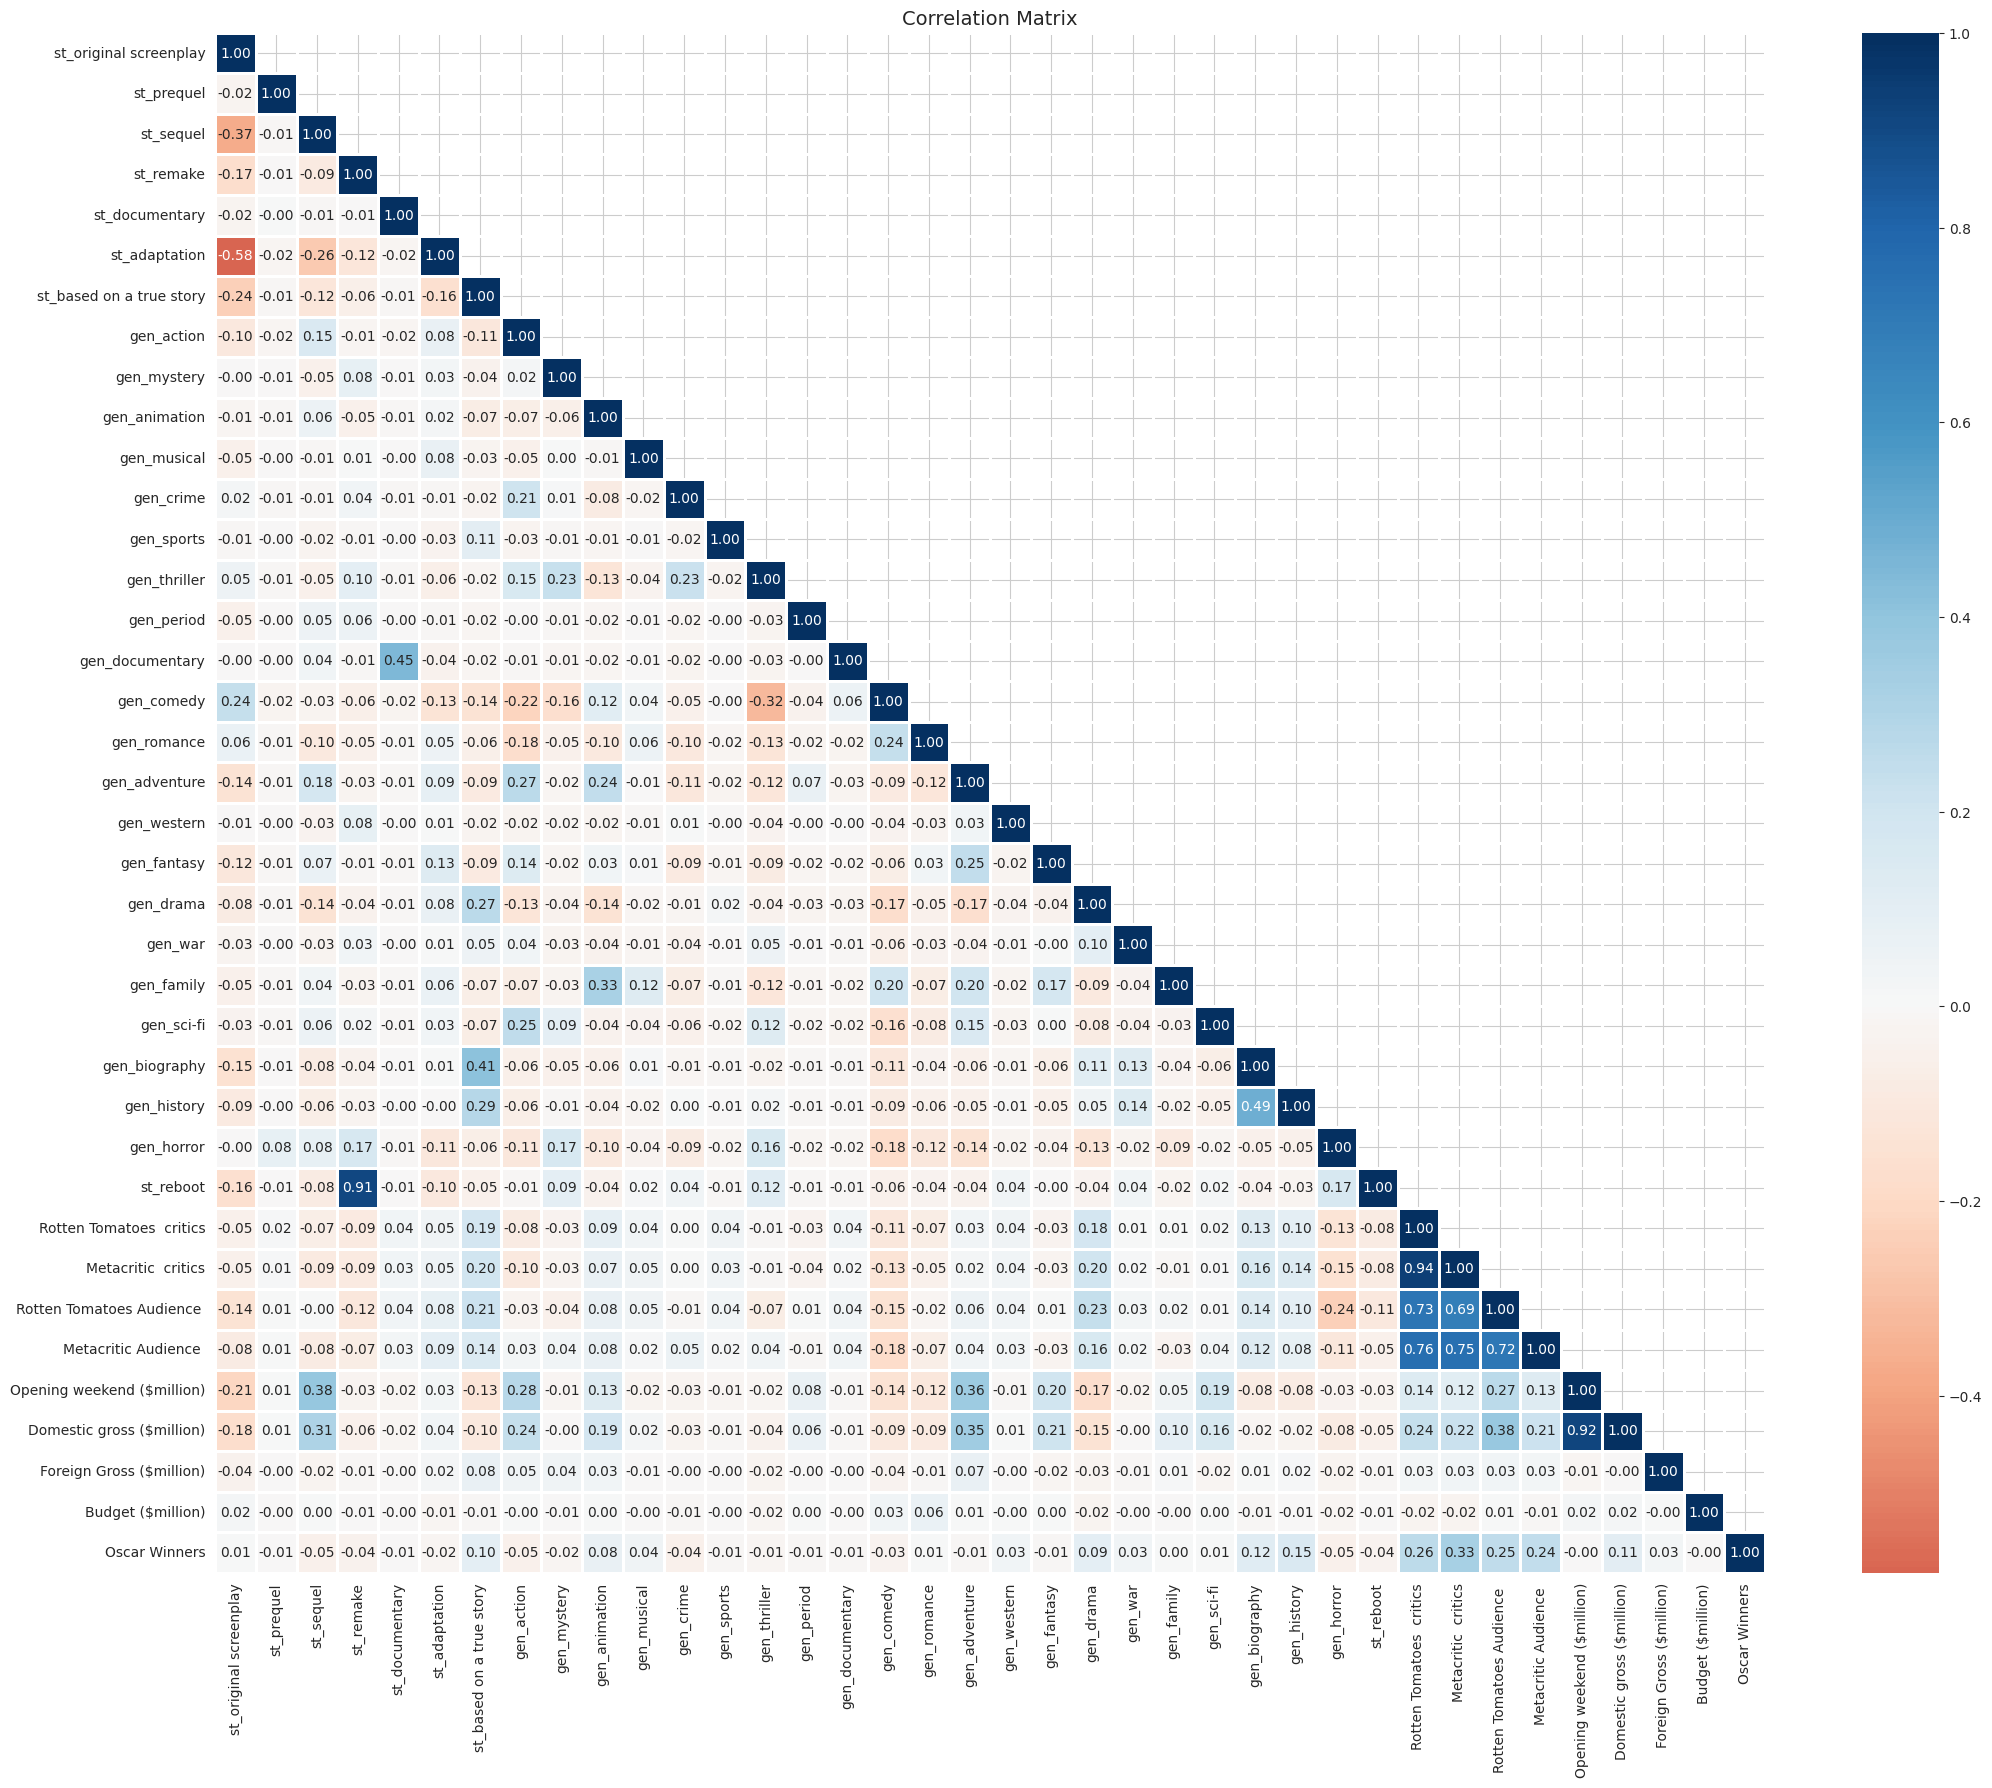

In [163]:
# Reset background style
sns.set_style('whitegrid')

corr = df.corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(corr, mask=mask, cmap=colormaps['RdBu'], annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

## 3.3 Build training data

### Balance Classes

In [166]:
df_oscar_winners = df[df['Oscar Winners'] == 1]

df_no_oscar_winners = df[df['Oscar Winners'] == 0].sample(56)

frames = [df_oscar_winners, df_no_oscar_winners]
df_nn = pd.concat(frames)
df_nn = df.sample(frac=1)

### Prepare training and testing splits

In [167]:
features = df_nn.drop(['Oscar Winners'], axis=1)
labels = df_nn['Oscar Winners']

X = torch.from_numpy(features.to_numpy(dtype='float32'))
y = torch.from_numpy(labels.to_numpy(dtype='float32')).unsqueeze(dim=1)

print(f'Shapes: X: {X.shape}, y: {y.shape}')

# Split at 30%
split_idx = int(X.shape[0] * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f'Split shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test {y_test.shape}:')

Shapes: X: torch.Size([1385, 37]), y: torch.Size([1385, 1])
Split shapes: X_train: torch.Size([969, 37]), y_train: torch.Size([969, 1]), X_test: torch.Size([416, 37]), y_test torch.Size([416, 1]):


In [170]:
print(f'Check tensors data types:\n{X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype}')

Check tensors data types:
(torch.float32, torch.float32, torch.float32, torch.float32)


## 3.4 Define binary classification neural network

### Oscar classification model class

In [1531]:
class OscarClassification(nn.Module):
    def __init__(self, input_features: int, output_features: int):
        super(OscarClassification, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=10),
            nn.ReLU(),
            # nn.Linear(in_features=20, out_features=20, dtype=torch.float32),
            # nn.ReLU(),
            nn.Linear(in_features=10, out_features=output_features)
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

### Define loss, optimizer and accuracy functions and initialize model

In [1532]:
# Accuracy calculator helper function
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [1533]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Device used: {device}')

# Initialize model
model = OscarClassification(input_features=X_train.shape[1], output_features=1).to(device)

# Loss function
loss_fn = torch.nn.BCEWithLogitsLoss().to(device)

# Optimizer functions
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01)

Device used: cuda


## 3.5 Train and test model

In [1534]:
# torch.use_deterministic_algorithms(True)
torch.manual_seed(42)

epochs = 400

X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# start_time = timer()
# start_resources = psutil.cpu_times()

for epoch in tqdm(range(epochs), desc='Training...'):
    model.train()

    # Forward passs
    y_hat = model(X_train)
    loss = loss_fn(y_hat, y_train)    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate prediction accuracy
    y_train_pred = torch.round(torch.sigmoid(y_hat))
    acc = accuracy_fn(y_pred=y_train_pred, y_true=y_train)

    ### Testing
    model.eval()
    with torch.inference_mode():

        y_hat = model(X_test)

        test_loss = loss_fn(y_hat, y_test)

        y_test_pred = torch.round(torch.sigmoid(y_hat))

        test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

    if epoch % int(epochs/10) == 0 or epoch == epochs-1:
        print(f'Epoch: {epoch:04d} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# end_time = timer()
# end_resources = start_resources = psutil.cpu_times()

# print(f'Resources: {start_resources}')


# print_train_time(start=start_time, end=end_time, device=device)

Training...:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch: 0000 | Loss: 2.2862, Acc: 46.15% | Test Loss: 3.7715, Test Acc: 29.41%
Epoch: 0040 | Loss: 0.3018, Acc: 84.62% | Test Loss: 0.3418, Test Acc: 85.29%
Epoch: 0080 | Loss: 0.2557, Acc: 87.18% | Test Loss: 0.3008, Test Acc: 88.24%
Epoch: 0120 | Loss: 0.2300, Acc: 89.74% | Test Loss: 0.2764, Test Acc: 88.24%
Epoch: 0160 | Loss: 0.2139, Acc: 91.03% | Test Loss: 0.2812, Test Acc: 88.24%
Epoch: 0200 | Loss: 0.1919, Acc: 92.31% | Test Loss: 0.2479, Test Acc: 85.29%
Epoch: 0240 | Loss: 0.1784, Acc: 93.59% | Test Loss: 0.2740, Test Acc: 88.24%
Epoch: 0280 | Loss: 0.1619, Acc: 93.59% | Test Loss: 0.3086, Test Acc: 82.35%
Epoch: 0320 | Loss: 0.1485, Acc: 93.59% | Test Loss: 0.2898, Test Acc: 85.29%
Epoch: 0360 | Loss: 0.1370, Acc: 93.59% | Test Loss: 0.3395, Test Acc: 82.35%
Epoch: 0399 | Loss: 0.1267, Acc: 96.15% | Test Loss: 0.2339, Test Acc: 88.24%


### Accuracy on test split

In [1535]:
with torch.inference_mode():
    X_test, y_test = X_test.to(device), y_test.to(device)
    y_test_logits = model(X_test)
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
print(f'Test total accuracy: {accuracy_fn(y_pred=y_test_pred, y_true=y_test):.2f}%')

Test total accuracy: 88.24%


### Test correct oscar guesses

In [1536]:
correct_oscar_guesses = 0
total_oscars = 0
for pred, truth in zip(y_test_logits, y_test):
    if truth == 1:
        total_oscars += 1
        if torch.round(torch.sigmoid(pred)) == 1:
            correct_oscar_guesses += 1
    

print(f'Correct oscar guesses on 30% test split: {correct_oscar_guesses} out of {total_oscars}')

Correct oscar guesses on 30% testing dataset: 17 out of 20


### Test accuracy on whole dataset